Third sandbox. Same dataset as the second one. This time, switched to `DecisionTreeClassifier`, which immediately improved the results. Once a bootstrap is done, this looks at the metrics generated across models using different `train_size`. That is, it calculates the metrics of bootstrapped predictions from a model trained on `train_size=0.1`, then the metrics of bootstrapped predictions from a model trained on `train_size=0.2`, and so on.

# Imports and setup

In [3]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
df = pd.read_csv('creditcard.csv')
print(df.columns)
print(df['Class'].value_counts())

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Class
0    284315
1       492
Name: count, dtype: int64


In [5]:
X_all = df[df.columns[:-1]].values
y_all = df['Class'].values

# Helper functions

In [7]:
def fit_with_size(X_sample, y_sample, seed, train_size, verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_sample,
        train_size=train_size,
        stratify=y_sample,
        random_state=seed  # make less random
    )

    if verbose:
        print("Fitting model with", train_size, "of the data...", end=' ')
        start_time = time()
    np.random.seed(seed)  # make less random
    model = DecisionTreeClassifier().fit(X_train, y_train)
    if verbose:
        end_time = time()
        print("done in", round(end_time-start_time), "seconds.")

    return model, X_test, y_test

In [8]:
def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return precision, recall, f1

In [9]:
def plot_metrics(df):
    plt.subplot(1, 3, 1)
    df["Precision"].plot.barh()
    plt.title("Precision")
    plt.subplot(1, 3, 2)
    df["Recall"].plot.barh()
    plt.title("Recall")
    plt.subplot(1, 3, 3)
    df["F1"].plot.barh()
    plt.title("F1")

# Bootstrapping a Decision Tree

In [11]:
# https://www.kdnuggets.com/2023/03/bootstrapping.html
def bootstrap(X, y, n_samples, train_size):
    results = []
    for i in tqdm(range(n_samples)):
        run = {}
        np.random.seed(i)  # make less random
        indices = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        X_sample = X[indices, :]
        y_sample = y[indices]

        model, X_test, y_test = fit_with_size(X_sample, y_sample, i, train_size)
        precision, recall, f1 = get_metrics(model, X_test, y_test)

        run["Seed"] = i
        run["Precision"] = precision
        run["Recall"] = recall
        run["F1"] = f1
        run["Indices"] = indices
        run["Model"] = model
        results.append(run)
    return pd.DataFrame(results)

In [12]:
pred_df = bootstrap(X_all, y_all, 10, 0.6)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:35<00:00, 21.60s/it]


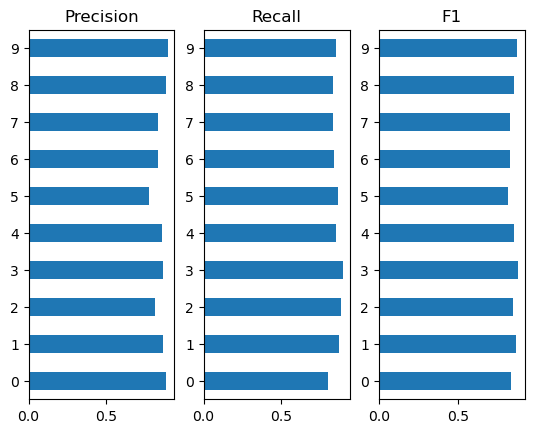

In [13]:
plot_metrics(pred_df)

In [31]:
pred_df.sort_values(by="F1", ascending=False).head()

,Seed,Precision,Recall,F1,Indices,Model
3,3,0.864734,0.895000,0.879607,"[71530, 198296, 77049, 48056, 11261, 215699, 2...",DecisionTreeClassifier()
9,9,0.892655,0.854054,0.872928,"[187006, 196534, 173819, 267158, 91261, 70209,...",DecisionTreeClassifier()
1,1,0.864130,0.873626,0.868852,"[128037, 267336, 73349, 117583, 21440, 229520,...",DecisionTreeClassifier()
4,4,0.860104,0.855670,0.857881,"[120705, 129384, 115144, 94601, 107578, 79981,...",DecisionTreeClassifier()
8,8,0.880682,0.833333,0.856354,"[70083, 25940, 149489, 256361, 231557, 236371,...",DecisionTreeClassifier()


# Majority voting

In [15]:
def weighted_predict(X, y, df, weight_by=None):
    n = y.shape
    y_weighted = np.zeros(n)
    all_predictions = []
    all_metrics = []
    
    models = df['Model'].values
    if weight_by is None:
        weights = [1 for _ in range(n)]
    else:
        weights = df[weight_by].values

    print("Making predictions...")
    for model, weight in tqdm(zip(models, weights)):
        y_raw = model.predict(X)
        all_predictions.append(y_raw)  # save this off for later comparison
        y_pred = y_raw * 2 - 1  # transform to range [-1, 1]
        y_pred = y_pred * weight
        y_weighted += y_pred
    # predictions are now in a range such that:
    # y >= 0 means a positive classification
    # y < 0 means a negative classification
    y_weighted = y_weighted >= 0
    all_predictions.append(y_weighted)

    print("Getting metrics...")
    for prediction in tqdm(all_predictions):
        d = {}
        d["Precision"] = precision_score(y, prediction)
        d["Recall"] = recall_score(y, prediction)
        d["F1"] = f1_score(y, prediction)
        all_metrics.append(d)

    print("Done.")
    return pd.DataFrame(all_metrics)

In [16]:
weight_df = weighted_predict(X_all, y_all, pred_df, 'F1')

Making predictions...


10it [00:00, 16.96it/s]


Getting metrics...


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.38it/s]

Done.


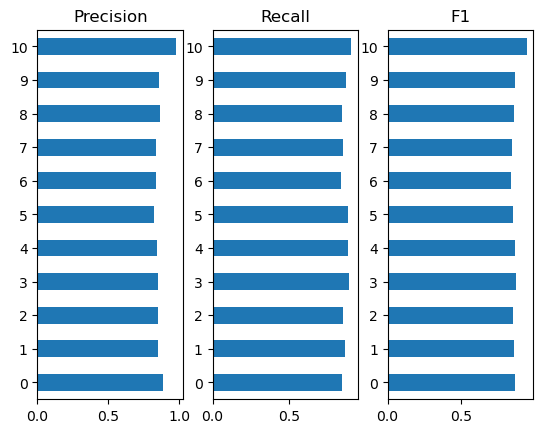

In [17]:
plot_metrics(weight_df)

In [18]:
weight_df.sort_values(by="F1", ascending=False).head()

,Precision,Recall,F1
10,0.980263,0.908537,0.943038
3,0.852427,0.892276,0.871897
0,0.883721,0.849593,0.866321
9,0.859719,0.871951,0.865792
4,0.841699,0.886179,0.863366


# Experiments with `train_size`

In [20]:
sizes = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8)
precision, recall, f1 = [], [], []
for s in sizes:
    print("Now working on size", s)
    size_pred_df = bootstrap(X_all, y_all, 5, s)
    size_weight_df = weighted_predict(X_all, y_all, size_pred_df, 'F1')
    p, r, f = size_weight_df.iloc[-1].values
    precision.append(p)
    recall.append(r)
    f1.append(f)
    print()
print("Done.")

Now working on size 0.1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.76s/it]


Making predictions...


5it [00:00, 17.68it/s]


Getting metrics...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.28it/s]


Done.

Now working on size 0.2


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.53s/it]


Making predictions...


5it [00:00, 18.56it/s]


Getting metrics...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.63it/s]


Done.

Now working on size 0.3


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:49<00:00,  9.95s/it]


Making predictions...


5it [00:00, 17.91it/s]


Getting metrics...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.58it/s]


Done.

Now working on size 0.4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.42s/it]


Making predictions...


5it [00:00, 16.51it/s]


Getting metrics...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.84it/s]


Done.

Now working on size 0.5


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:34<00:00, 18.81s/it]


Making predictions...


5it [00:00, 15.90it/s]


Getting metrics...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.36it/s]


Done.

Now working on size 0.6


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:55<00:00, 23.02s/it]


Making predictions...


5it [00:00, 17.76it/s]


Getting metrics...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]


Done.

Now working on size 0.7


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:59<00:00, 23.97s/it]


Making predictions...


5it [00:00, 19.20it/s]


Getting metrics...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.47it/s]


Done.

Now working on size 0.8


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.34s/it]


Making predictions...


5it [00:00, 17.99it/s]


Getting metrics...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.40it/s]

Done.

Done.


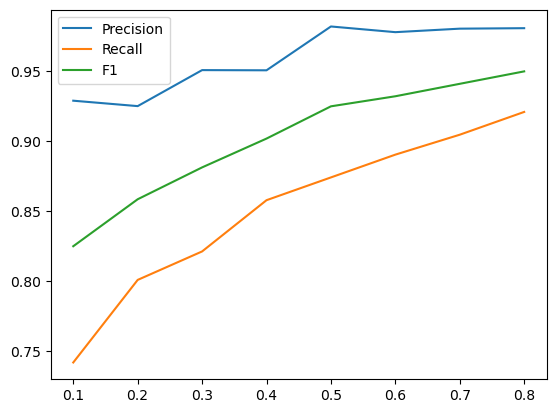

In [21]:
ax = plt.plot(sizes, precision, label="Precision")
plt.plot(sizes, recall, label="Recall")
plt.plot(sizes, f1, label="F1")
_ = plt.legend()

In [30]:
for s, p, r, f in zip(sizes, precision, recall, f1):
    print(f"For size {s}, precision={p} recall={r} f1={f}")

For size 0.1, precision=0.9287531806615776 recall=0.741869918699187 f1=0.8248587570621468
For size 0.2, precision=0.9248826291079812 recall=0.8008130081300813 f1=0.8583877995642701
For size 0.3, precision=0.9505882352941176 recall=0.8211382113821138 f1=0.88113413304253
For size 0.4, precision=0.9504504504504504 recall=0.8577235772357723 f1=0.9017094017094017
For size 0.5, precision=0.9817351598173516 recall=0.8739837398373984 f1=0.9247311827956989
For size 0.6, precision=0.9776785714285714 recall=0.8902439024390244 f1=0.9319148936170213
For size 0.7, precision=0.9801762114537445 recall=0.9044715447154471 f1=0.9408033826638478
For size 0.8, precision=0.9805194805194806 recall=0.9207317073170732 f1=0.949685534591195
